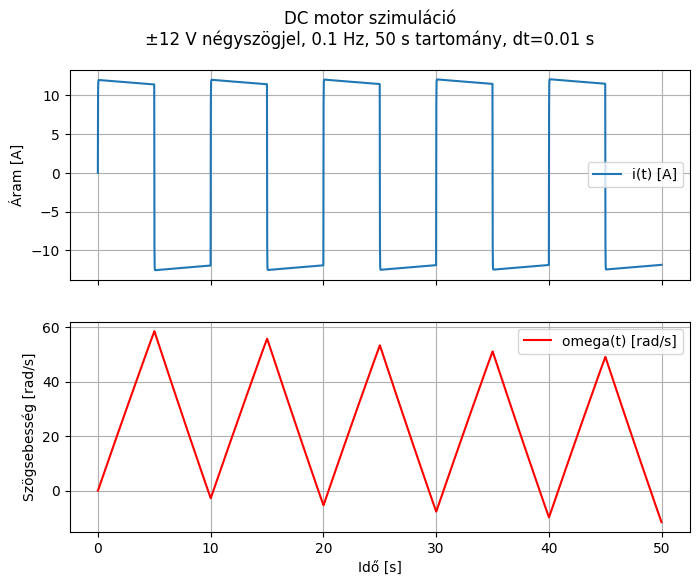

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

class DCMotor:
    """
    Egyszerű DC motor modell,
    u(t) bemenetet (négyszögjel) kapcsol a motorra,
    a kimenet a szögsebesség (omega) [rad/s].
    """
    def __init__(self,
                 R=1.0,          # Armatúra ellenállás [ohm]
                 L=0.01,         # Armatúra induktivitás [H]
                 k=0.01,         # kϕ (nyomatéki/feszültségállandó) [Nm/A, V/(rad/s)]
                 J=0.01,         # Tehetetlenségi nyomaték [kg*m^2]
                 b=0.0,          # Viszkózus súrlódás [N*m*s/rad]
                 T_load=0.0,     # Terhelő nyomaték [Nm]
                 V_high=12.0,    # Négyszögjel + szint [V]
                 V_low=-12.0,    # Négyszögjel - szint [V]
                 freq=0.1):      # Négyszögjel frekvenciája [Hz]
        """
        Alapbeállítás szerint: ±12 V-os négyszögjel, 0.1 Hz frekvenciával (10 s periódus).
        """
        self.R = R
        self.L = L
        self.k = k
        self.J = J
        self.b = b
        self.T_load = T_load
        self.V_high = V_high
        self.V_low = V_low
        self.freq = freq

    def input_voltage(self, t):
        """
        Négyszögjel generálása:
        félperiódusonként vált a V_high és a V_low között.
        """
        period = 1.0 / self.freq  # pl. 10 s
        if (t % period) < (period / 2.0):
            return self.V_high
        else:
            return self.V_low

    def motor_ode(self, x, t):
        """
        A motor differenciálegyenlete:
          L di/dt = u(t) - R*i - k*omega
          J d(omega)/dt = k*i - b*omega - T_load

        x = [i, omega]
        """
        i, omega = x
        u_t = self.input_voltage(t)

        di_dt = (u_t - self.R * i - self.k * omega) / self.L
        domega_dt = (self.k * i - self.b * omega - self.T_load) / self.J
        return [di_dt, domega_dt]

    def simulate(self, x0=None, t_max=10.0, dt=1e-3):
        """
        A motor szimulációja t=0..t_max időtartományban,
        dt lépésközzel.

        x0 = [i(0), omega(0)] a kezdeti állapot
        """
        if x0 is None:
            x0 = [0.0, 0.0]

        t_vals = np.arange(0, t_max, dt)
        sol = odeint(self.motor_ode, x0, t_vals)
        i_vals = sol[:, 0]
        omega_vals = sol[:, 1]
        return t_vals, i_vals, omega_vals


# Főrész
if __name__ == "__main__":
    # Példányosítjuk a motort a megadott paraméterekkel
    motor = DCMotor(
        R=1.0,
        L=0.01,
        k=0.01,
        J=0.01,
        b=0.0,
        T_load=0.0,
        V_high=12.0,
        V_low=-12.0,
        freq=0.1   # 0.1 Hz -> 10 s periódusidő
    )

    # 50 s szimuláció, lépésköz: dt = 0.01 s
    t_max = 50.0
    dt = 10e-3  # 0.01 s

    # Futassuk a szimulációt
    t, i_vals, omega_vals = motor.simulate(t_max=t_max, dt=dt)

    # Ábrázolás
    fig, axs = plt.subplots(2, 1, figsize=(8,6), sharex=True)

    axs[0].plot(t, i_vals, label='i(t) [A]')
    axs[0].set_ylabel('Áram [A]')
    axs[0].grid(True)
    axs[0].legend()

    axs[1].plot(t, omega_vals, 'r', label='omega(t) [rad/s]')
    axs[1].set_xlabel('Idő [s]')
    axs[1].set_ylabel('Szögsebesség [rad/s]')
    axs[1].grid(True)
    axs[1].legend()

    plt.suptitle("DC motor szimuláció\n±12 V négyszögjel, 0.1 Hz, 50 s tartomány, dt=0.01 s")
    plt.show()


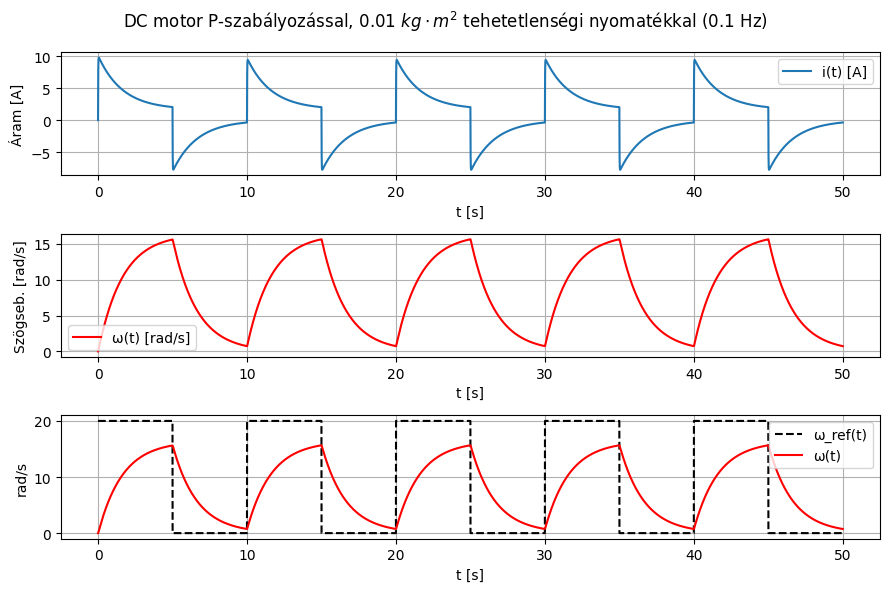

In [8]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def clamp(value, vmin, vmax):
    """ Egyszerű szaturációs függvény. """
    return max(vmin, min(value, vmax))

class DCMotorSquareWaveRefPControl:
    """
    DC motor P-szabályozással, amelynél a referencia
    szögsebesség (w_ref) négyszögjelként változik.
    """
    def __init__(self,
                 R=1.0,           # Armatúra ellenállás [ohm]
                 L=0.01,          # Armatúra induktivitás [H]
                 k=0.01,          # kϕ (Nm/A, V/(rad/s))
                 J=0.01,          # Tehetetlenségi nyomaték [kg*m^2]
                 b=0.0,           # Viszkózus súrlódás [N*m*s/rad]
                 T_load=0.0,      # Terhelő nyomaték [Nm]
                 Kp=0.5,          # P-szabályozó erősítés
                 w_high=50.0,     # Négyszögjel "felső" szögsebesség [rad/s]
                 w_low=0.0,       # Négyszögjel "alsó" szögsebesség [rad/s]
                 freq=0.05,       # Négyszög-frekvencia [Hz]
                 Vmax=12.0):      # Feszültség szaturáció ± [V]
        self.R = R
        self.L = L
        self.k = k
        self.J = J
        self.b = b
        self.T_load = T_load
        self.Kp = Kp
        self.w_high = w_high
        self.w_low = w_low
        self.freq = freq
        self.Vmax = Vmax

    def w_ref(self, t):
        """
        Négyszögjel generálása a sebességreferenciához:
        félperiódusonként w_high vagy w_low.
        """
        T = 1.0 / self.freq  # periódusidő
        if (t % T) < (T / 2.0):
            return self.w_high
        else:
            return self.w_low

    def motor_ode(self, x, t):
        """
        A motor állapotai: x = [i, omega].
        Differenciálegyenletek:
          L di/dt = u(t) - R*i - k*omega
          J d(omega)/dt = k*i - b*omega - T_load
        
        A bemenetet (u) a P-szabályozó adja:
          e = w_ref(t) - omega
          u_raw = Kp * e
          u = clamp(u_raw, -Vmax, Vmax)
        """
        i, omega = x

        # Referencia (négyszögjel) beolvasása
        w_r = self.w_ref(t)

        # Sebességhiba
        e = w_r - omega

        # P-szabályozó + szaturáció
        u_raw = self.Kp * e
        u = clamp(u_raw, -self.Vmax, self.Vmax)

        # Elektromos dinamika
        di_dt = (u - self.R*i - self.k*omega) / self.L
        # Mechanikai dinamika
        domega_dt = (self.k*i - self.b*omega - self.T_load) / self.J

        return [di_dt, domega_dt]

    def simulate(self, x0=None, t_max=10.0, dt=1e-3):
        """
        Szimuláció a t=0..t_max időintervallumon,
        dt lépésközzel. x0 = [i(0), omega(0)]
        """
        if x0 is None:
            x0 = [0.0, 0.0]

        t_vals = np.arange(0, t_max, dt)
        sol = odeint(self.motor_ode, x0, t_vals)

        i_vals = sol[:, 0]
        w_vals = sol[:, 1]
        return t_vals, i_vals, w_vals


if __name__ == "__main__":
    # Példa motorparaméterek
    motor = DCMotorSquareWaveRefPControl(
        R=1.0,
        L=0.01,
        k=0.01,
        J=0.01,
        b=0.001,   # Kis mértékű viszkózus súrlódás
        T_load=0.0,
        Kp=0.5,    # P-szabályozó erősítés
        w_high=20.0,
        w_low=0.0,
        freq=0.1, # 1Hz referenciaváltás
        Vmax=12.0  # ±12 V szaturáció
    )

    # 10 másodperces szimuláció, 1e-3 lépésközzel
    t_max = 50.0
    dt = 1e-3
    t, i_vals, w_vals = motor.simulate(t_max=t_max, dt=dt)

    # Ábrázoljuk a kapott eredményeket
    plt.figure(figsize=(9,6))

    # Áram
    plt.subplot(3,1,1)
    plt.plot(t, i_vals, label='i(t) [A]')
    plt.grid(True)
    plt.xlabel('t [s]')
    plt.ylabel('Áram [A]')
    plt.legend()

    # Sebesség
    plt.subplot(3,1,2)
    plt.plot(t, w_vals, 'r', label='ω(t) [rad/s]')
    plt.grid(True)
    plt.xlabel('t [s]')
    plt.ylabel('Szögseb. [rad/s]')
    plt.legend()

    # Referencia és sebesség összehasonlítás
    plt.subplot(3,1,3)
    # Kirajzoljuk a referencia négyszögjelet is
    w_ref_vals = np.array([motor.w_ref(ti) for ti in t])
    plt.plot(t, w_ref_vals, 'k--', label='ω_ref(t)')
    plt.plot(t, w_vals, 'r', label='ω(t)')
    plt.grid(True)
    plt.xlabel('t [s]')
    plt.ylabel('rad/s')
    plt.legend()

    plt.suptitle("DC motor P-szabályozással, 0.01 $kg \cdot m^2$ tehetetlenségi nyomatékkal (0.1 Hz)")
    plt.tight_layout()
    plt.show()


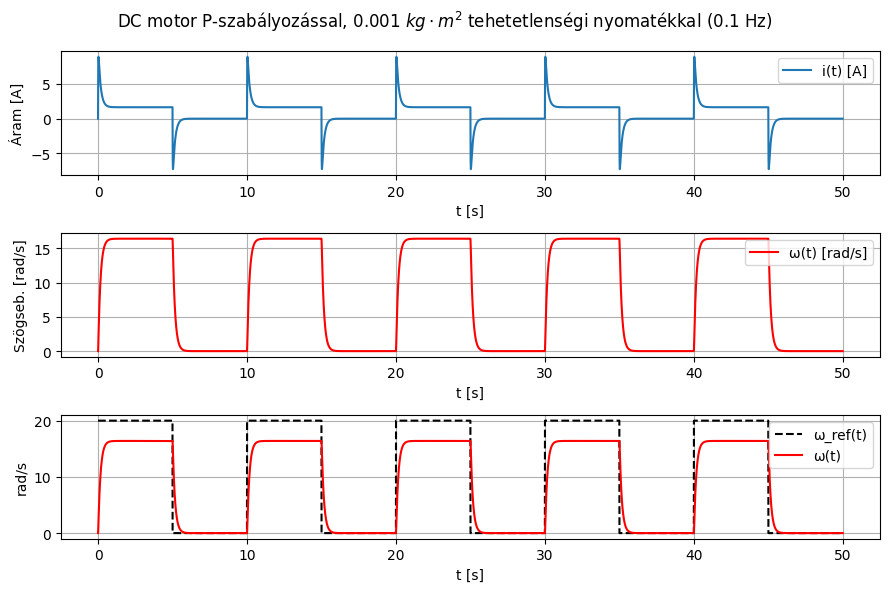

In [9]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def clamp(value, vmin, vmax):
    """ Egyszerű szaturációs függvény. """
    return max(vmin, min(value, vmax))

class DCMotorSquareWaveRefPControl:
    """
    DC motor P-szabályozással, amelynél a referencia
    szögsebesség (w_ref) négyszögjelként változik.
    """
    def __init__(self,
                 R=1.0,           # Armatúra ellenállás [ohm]
                 L=0.01,          # Armatúra induktivitás [H]
                 k=0.01,          # kϕ (Nm/A, V/(rad/s))
                 J=0.001,         # Kisebb tehetetlenségi nyomaték [kg*m^2]
                 b=0.001,         # Kis viszkózus súrlódás [N*m*s/rad]
                 T_load=0.0,      # Terhelő nyomaték [Nm]
                 Kp=0.5,          # P-szabályozó erősítés
                 w_high=20.0,     # Négyszögjel "felső" szögsebesség [rad/s]
                 w_low=0.0,       # Négyszögjel "alsó" szögsebesség [rad/s]
                 freq=0.1,        # Négyszög-frekvencia [Hz]
                 Vmax=12.0):      # Feszültség szaturáció ± [V]
        self.R = R
        self.L = L
        self.k = k
        self.J = J
        self.b = b
        self.T_load = T_load
        self.Kp = Kp
        self.w_high = w_high
        self.w_low = w_low
        self.freq = freq
        self.Vmax = Vmax

    def w_ref(self, t):
        """
        Négyszögjel generálása a sebességreferenciához:
        félperiódusonként w_high vagy w_low.
        A teljes periódusidő 1/freq, itt 10 s.
        """
        T = 1.0 / self.freq  # periódusidő
        if (t % T) < (T / 2.0):
            return self.w_high
        else:
            return self.w_low

    def motor_ode(self, x, t):
        """
        A motor állapotai: x = [i, omega].
        Differenciálegyenletek:
          L di/dt = u(t) - R*i - k*omega
          J d(omega)/dt = k*i - b*omega - T_load
        
        A bemenetet (u) a P-szabályozó adja:
          e = w_ref(t) - omega
          u_raw = Kp * e
          u = clamp(u_raw, -Vmax, Vmax)
        """
        i, omega = x

        # 1) Referencia (négyszögjel) beolvasása
        w_r = self.w_ref(t)

        # 2) Sebességhiba
        e = w_r - omega

        # 3) P-szabályozó + szaturáció
        u_raw = self.Kp * e
        u = clamp(u_raw, -self.Vmax, self.Vmax)

        # 4) Elektromos dinamika
        di_dt = (u - self.R*i - self.k*omega) / self.L
        # 5) Mechanikai dinamika
        domega_dt = (self.k*i - self.b*omega - self.T_load) / self.J

        return [di_dt, domega_dt]

    def simulate(self, x0=None, t_max=50.0, dt=1e-3):
        """
        Szimuláció a t=0..t_max időintervallumon,
        dt lépésközzel. x0 = [i(0), omega(0)]
        """
        if x0 is None:
            x0 = [0.0, 0.0]

        t_vals = np.arange(0, t_max, dt)
        sol = odeint(self.motor_ode, x0, t_vals)

        i_vals = sol[:, 0]
        w_vals = sol[:, 1]
        return t_vals, i_vals, w_vals


if __name__ == "__main__":
    # Példa motorparaméterek
    motor = DCMotorSquareWaveRefPControl(
        R=1.0,
        L=0.01,
        k=0.01,
        J=0.001,   # Kisebb tehetetlenségi nyomaték
        b=0.001,   # Kis mértékű viszkózus súrlódás
        T_load=0.0,
        Kp=0.5,    # P-szabályozó erősítés
        w_high=20.0,
        w_low=0.0,
        freq=0.1,  # 10 s a periódusidő (0.1 Hz)
        Vmax=12.0  # ±12 V szaturáció
    )

    # 50 másodperces szimuláció, 1e-3 lépésközzel
    t_max = 50.0
    dt = 1e-3
    t, i_vals, w_vals = motor.simulate(t_max=t_max, dt=dt)

    # Ábrázoljuk a kapott eredményeket
    plt.figure(figsize=(9,6))

    # Áram
    plt.subplot(3,1,1)
    plt.plot(t, i_vals, label='i(t) [A]')
    plt.grid(True)
    plt.xlabel('t [s]')
    plt.ylabel('Áram [A]')
    plt.legend()

    # Sebesség
    plt.subplot(3,1,2)
    plt.plot(t, w_vals, 'r', label='ω(t) [rad/s]')
    plt.grid(True)
    plt.xlabel('t [s]')
    plt.ylabel('Szögseb. [rad/s]')
    plt.legend()

    # Referencia és sebesség összehasonlítás
    plt.subplot(3,1,3)
    w_ref_vals = np.array([motor.w_ref(ti) for ti in t])
    plt.plot(t, w_ref_vals, 'k--', label='ω_ref(t)')
    plt.plot(t, w_vals, 'r', label='ω(t)')
    plt.grid(True)
    plt.xlabel('t [s]')
    plt.ylabel('rad/s')
    plt.legend()

    plt.suptitle("DC motor P-szabályozással, 0.001 $kg \cdot m^2$ tehetetlenségi nyomatékkal (0.1 Hz) ")
    plt.tight_layout()
    plt.show()


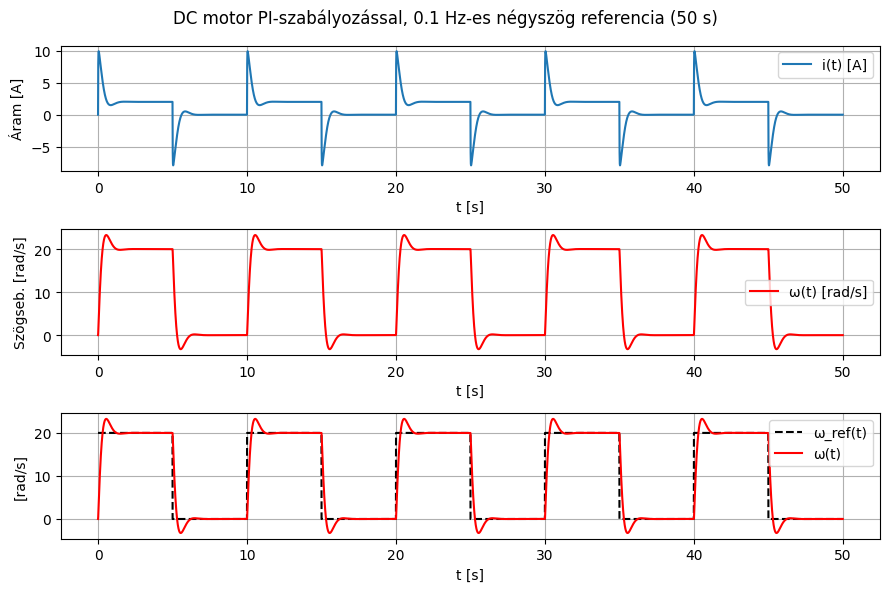

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def clamp(value, vmin, vmax):
    """Egyszerű szaturációs függvény."""
    return max(vmin, min(value, vmax))

class DCMotorSquareWaveRefPIControl:
    """
    DC motor PI-szabályozással, ahol a
    szögsebesség-referencia négyszögjel (w_high / w_low) 
    0.1 Hz-cel vált.
    """

    def __init__(self,
                 R=1.0,           # Armatúra ellenállás [ohm]
                 L=0.01,          # Armatúra induktivitás [H]
                 k=0.01,          # kϕ [Nm/A és V/(rad/s)]
                 J=0.001,         # Kisebb tehetetlenségi nyomaték [kg*m^2]
                 b=0.001,         # Kis viszkózus súrlódás [N*m*s/rad]
                 T_load=0.0,      # Terhelő nyomaték [Nm]
                 Kp=0.5,          # PI-szabályozó arányos erősítés
                 Ki=2.0,          # PI-szabályozó integráló erősítés
                 w_high=20.0,     # Négyszögjel "felső" szögsebesség [rad/s]
                 w_low=0.0,       # Négyszögjel "alsó" szögsebesség [rad/s]
                 freq=0.1,        # Négyszög-frekvencia [Hz]
                 Vmax=12.0):      # Feszültség szaturáció [±V]
        self.R = R
        self.L = L
        self.k = k
        self.J = J
        self.b = b
        self.T_load = T_load
        self.Kp = Kp
        self.Ki = Ki
        self.w_high = w_high
        self.w_low = w_low
        self.freq = freq
        self.Vmax = Vmax

    def w_ref(self, t):
        """
        Négyszögjel generálása a sebességreferenciához:
        félperiódusonként w_high vagy w_low.
        Periódusidő: 1/freq = 10 s (0.1 Hz).
        """
        T = 1.0 / self.freq
        if (t % T) < (T / 2.0):
            return self.w_high
        else:
            return self.w_low

    def motor_ode(self, x, t):
        """
        A motor állapotai: x = [i, omega, e_int].
          - i(t): armatúraáram
          - omega(t): szögsebesség
          - e_int(t): az integrátor állapota (az e(t) hibát integrálja)

        A PI szabályozó:
          e(t) = w_ref(t) - omega(t)
          u_raw(t) = Kp*e(t) + Ki*e_int(t)
          u(t) = clamp(u_raw, -Vmax, Vmax)

        Motor differenciálegyenletek:
          L di/dt = u - R*i - k*omega
          J d(omega)/dt = k*i - b*omega - T_load
          d(e_int)/dt = e(t)
        """
        i, omega, e_int = x

        # 1) Négyszögjel referencia
        w_r = self.w_ref(t)

        # 2) Hiba
        e = w_r - omega

        # 3) PI szabályozó
        u_raw = self.Kp * e + self.Ki * e_int
        u = clamp(u_raw, -self.Vmax, self.Vmax)

        # 4) Elektromos differenciálegyenlet
        di_dt = (u - self.R*i - self.k*omega) / self.L
        # 5) Mechanikai differenciálegyenlet
        domega_dt = (self.k*i - self.b*omega - self.T_load) / self.J
        # 6) Integrátor állapota
        de_int_dt = e

        return [di_dt, domega_dt, de_int_dt]

    def simulate(self, x0=None, t_max=50.0, dt=1e-3):
        """
        Szimuláció: t=0..t_max, dt lépésközzel.
        x0 = [i(0), omega(0), e_int(0)]
        """
        if x0 is None:
            x0 = [0.0, 0.0, 0.0]  # kezdeti áram, szögsebesség, integrátor=0

        t_vals = np.arange(0, t_max, dt)
        from scipy.integrate import odeint
        sol = odeint(self.motor_ode, x0, t_vals)

        i_vals = sol[:, 0]
        w_vals = sol[:, 1]
        e_int_vals = sol[:, 2]
        return t_vals, i_vals, w_vals, e_int_vals


if __name__ == "__main__":
    # Példa paraméterek a PI szabályozáshoz
    motor = DCMotorSquareWaveRefPIControl(
        R=1.0,
        L=0.01,
        k=0.01,
        J=0.001,
        b=0.001,
        T_load=0.0,
        Kp=0.5,    # Arányos erősítés
        Ki=2.0,    # Integráló erősítés (próbáld hangolni)
        w_high=20.0,
        w_low=0.0,
        freq=0.1,  # 0.1 Hz -> 10 s periódus
        Vmax=12.0
    )

    # 50 s hosszú szimuláció, 1e-3 s lépésközzel
    t_max = 50.0
    dt = 1e-3
    t, i_vals, w_vals, e_int_vals = motor.simulate(t_max=t_max, dt=dt)

    # Ábrázolás
    plt.figure(figsize=(9,6))

    # 1. Áram
    plt.subplot(3,1,1)
    plt.plot(t, i_vals, label='i(t) [A]')
    plt.xlabel('t [s]')
    plt.ylabel('Áram [A]')
    plt.grid(True)
    plt.legend()

    # 2. Sebesség
    plt.subplot(3,1,2)
    plt.plot(t, w_vals, 'r', label='ω(t) [rad/s]')
    plt.xlabel('t [s]')
    plt.ylabel('Szögseb. [rad/s]')
    plt.grid(True)
    plt.legend()

    # 3. Sebesség + referencia
    plt.subplot(3,1,3)
    w_ref_vals = np.array([motor.w_ref(tt) for tt in t])
    plt.plot(t, w_ref_vals, 'k--', label='ω_ref(t)')
    plt.plot(t, w_vals, 'r', label='ω(t)')
    plt.xlabel('t [s]')
    plt.ylabel('[rad/s]')
    plt.grid(True)
    plt.legend()

    plt.suptitle("DC motor PI-szabályozással, 0.1 Hz-es négyszög referencia (50 s)")
    plt.tight_layout()
    plt.show()


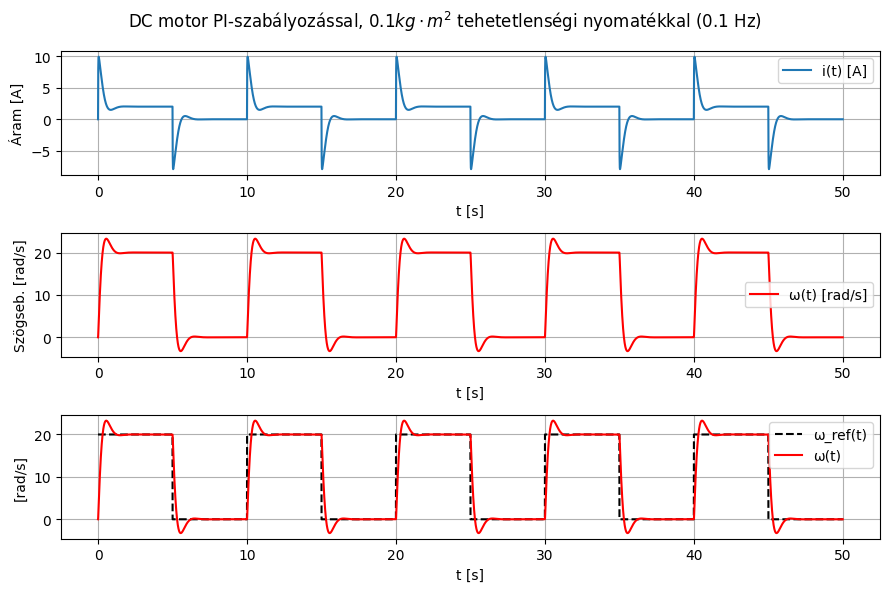

In [13]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def clamp(value, vmin, vmax):
    """Egyszerű szaturációs függvény."""
    return max(vmin, min(value, vmax))

class DCMotorSquareWaveRefPIControl:
    """
    DC motor PI-szabályozással, ahol a
    szögsebesség-referencia négyszögjel (w_high / w_low) 
    0.1 Hz-cel vált.
    """

    def __init__(self,
                 R=1.0,           # Armatúra ellenállás [ohm]
                 L=0.01,          # Armatúra induktivitás [H]
                 k=0.1,          # kϕ [Nm/A és V/(rad/s)]
                 J=0.1,         # Kisebb tehetetlenségi nyomaték [kg*m^2]
                 b=0.001,         # Kis viszkózus súrlódás [N*m*s/rad]
                 T_load=0.0,      # Terhelő nyomaték [Nm]
                 Kp=0.5,          # PI-szabályozó arányos erősítés
                 Ki=2.0,          # PI-szabályozó integráló erősítés
                 w_high=20.0,     # Négyszögjel "felső" szögsebesség [rad/s]
                 w_low=0.0,       # Négyszögjel "alsó" szögsebesség [rad/s]
                 freq=0.1,        # Négyszög-frekvencia [Hz]
                 Vmax=12.0):      # Feszültség szaturáció [±V]
        self.R = R
        self.L = L
        self.k = k
        self.J = J
        self.b = b
        self.T_load = T_load
        self.Kp = Kp
        self.Ki = Ki
        self.w_high = w_high
        self.w_low = w_low
        self.freq = freq
        self.Vmax = Vmax

    def w_ref(self, t):
        """
        Négyszögjel generálása a sebességreferenciához:
        félperiódusonként w_high vagy w_low.
        Periódusidő: 1/freq = 10 s (0.1 Hz).
        """
        T = 1.0 / self.freq
        if (t % T) < (T / 2.0):
            return self.w_high
        else:
            return self.w_low

    def motor_ode(self, x, t):
        """
        A motor állapotai: x = [i, omega, e_int].
          - i(t): armatúraáram
          - omega(t): szögsebesség
          - e_int(t): az integrátor állapota (az e(t) hibát integrálja)

        A PI szabályozó:
          e(t) = w_ref(t) - omega(t)
          u_raw(t) = Kp*e(t) + Ki*e_int(t)
          u(t) = clamp(u_raw, -Vmax, Vmax)

        Motor differenciálegyenletek:
          L di/dt = u - R*i - k*omega
          J d(omega)/dt = k*i - b*omega - T_load
          d(e_int)/dt = e(t)
        """
        i, omega, e_int = x

        # 1) Négyszögjel referencia
        w_r = self.w_ref(t)

        # 2) Hiba
        e = w_r - omega

        # 3) PI szabályozó
        u_raw = self.Kp * e + self.Ki * e_int
        u = clamp(u_raw, -self.Vmax, self.Vmax)

        # 4) Elektromos differenciálegyenlet
        di_dt = (u - self.R*i - self.k*omega) / self.L
        # 5) Mechanikai differenciálegyenlet
        domega_dt = (self.k*i - self.b*omega - self.T_load) / self.J
        # 6) Integrátor állapota
        de_int_dt = e

        return [di_dt, domega_dt, de_int_dt]

    def simulate(self, x0=None, t_max=50.0, dt=1e-3):
        """
        Szimuláció: t=0..t_max, dt lépésközzel.
        x0 = [i(0), omega(0), e_int(0)]
        """
        if x0 is None:
            x0 = [0.0, 0.0, 0.0]  # kezdeti áram, szögsebesség, integrátor=0

        t_vals = np.arange(0, t_max, dt)
        from scipy.integrate import odeint
        sol = odeint(self.motor_ode, x0, t_vals)

        i_vals = sol[:, 0]
        w_vals = sol[:, 1]
        e_int_vals = sol[:, 2]
        return t_vals, i_vals, w_vals, e_int_vals


if __name__ == "__main__":
    # Példa paraméterek a PI szabályozáshoz
    motor = DCMotorSquareWaveRefPIControl(
        R=1.0,
        L=0.01,
        k=0.01,
        J=0.001,
        b=0.001,
        T_load=0.0,
        Kp=0.5,    # Arányos erősítés
        Ki=2.0,    # Integráló erősítés (próbáld hangolni)
        w_high=20.0,
        w_low=0.0,
        freq=0.1,  # 0.1 Hz -> 10 s periódus
        Vmax=12.0
    )

    # 50 s hosszú szimuláció, 1e-3 s lépésközzel
    t_max = 50.0
    dt = 1e-3
    t, i_vals, w_vals, e_int_vals = motor.simulate(t_max=t_max, dt=dt)

    # Ábrázolás
    plt.figure(figsize=(9,6))

    # 1. Áram
    plt.subplot(3,1,1)
    plt.plot(t, i_vals, label='i(t) [A]')
    plt.xlabel('t [s]')
    plt.ylabel('Áram [A]')
    plt.grid(True)
    plt.legend()

    # 2. Sebesség
    plt.subplot(3,1,2)
    plt.plot(t, w_vals, 'r', label='ω(t) [rad/s]')
    plt.xlabel('t [s]')
    plt.ylabel('Szögseb. [rad/s]')
    plt.grid(True)
    plt.legend()

    # 3. Sebesség + referencia
    plt.subplot(3,1,3)
    w_ref_vals = np.array([motor.w_ref(tt) for tt in t])
    plt.plot(t, w_ref_vals, 'k--', label='ω_ref(t)')
    plt.plot(t, w_vals, 'r', label='ω(t)')
    plt.xlabel('t [s]')
    plt.ylabel('[rad/s]')
    plt.grid(True)
    plt.legend()

    plt.suptitle("DC motor PI-szabályozással, $0.1 kg \cdot m^2 $ tehetetlenségi nyomatékkal (0.1 Hz)")
    plt.tight_layout()
    plt.show()
